In [1]:
import pandas as pd
import numpy as np
from datetime import date, time, datetime, timedelta

import plotly.graph_objects as go

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter

In [2]:
PATH = r'D:\WORKS\PolimerSolve\Comsol\tables'
STD_VALUES = {
        'k1': 1E+9,
        'k2': 1.00E+09,
        'k3': 1.00E+09,
        'k4': 1.00E+09,
        'k5': 2000,
        'k6': 2.00E+00,
        'k7': 0.05,
        'k8': 1.00E+00,
        'k9': 0.001,
        'k10': 1.00E+09,
        'k11': 1.00E-05,
    }

In [3]:
def df_from_comsol(
    name,
    from_name=r'\out.csv',
    temp_name=r'\temp.csv',
):
    with open(PATH + from_name, 'r') as file:
        lines = file.readlines()

    with open(PATH + temp_name, 'w') as file:
        for line in lines[4:]:
            file.write(line)
    df = pd.read_csv(PATH + r'\temp.csv')
    df = df.rename(
        columns={
            df.columns[0]: df.columns[0].replace('% ', ''),
            'Time=1E-4, timeint(0, 1E-4, D)': 'target',
        })
    df['name'] = name
    df['date'] = datetime.now().replace(second=0, microsecond=0)
    return df


def add_notes(from_name=r'\out.csv'):
    name = ''
    while True:
        name = input('Name (q for quit): ')
        if (name != '') and (name != 'q'):
            try:
                old_df = pd.read_excel(PATH + r'\base.xlsx', index_col=0)
            except FileNotFoundError:
                old_df = pd.DataFrame(
                    {key: [None]
                     for key in STD_VALUES.keys()})
                old_df = old_df.drop(index=0)

            new_df = pd.concat(
                [old_df, df_from_comsol(name, from_name=from_name)],
                ignore_index=True,
            )
            new_df = new_df.fillna(STD_VALUES)
            new_df.to_excel(PATH + r'\base.xlsx')

            return new_df, old_df
        elif name == 'q':
            break


def get_const_diap(df, print_only=False):
    useless = [
        'light',
        'target',
        'name',
        'date',
    ]
    values = {}
    for i in df:
        if i in useless: continue
        values.update({i: df[i].unique()})
        if print_only: print(f'{i:<5}:{values[i]}')

    if not print_only: return values


# Check all notes

In [4]:
df = pd.read_excel(PATH + r'\base.xlsx', index_col=0)
# df = df[(df['name']=='test2')|(df['name']=='new')]

In [5]:
df['flag'] = df.groupby(list(STD_VALUES.keys())).ngroup()
df['name'].unique()

array(['start', 'continue', 'test', 'new', 'new2', 'big', 'test2'],
      dtype=object)

In [6]:
fig = go.FigureWidget()
fig.add_trace(
    go.Scatter(
        name='',
        x=df['light'],
        y=df['target'],
        mode='markers',
        marker={'color': df['flag']},
        text=df[['flag','name']],
        hovertemplate="""light: %{x:.1e}
        <br>integral: %{y:.2s}
        <br>Flag: %{text[0]}
        <br>Name: %{text[1]}
        """
        ,
    ))
fig.update_layout(
    height=500,
    margin={'r': 0, 'l': 0, 't': 0, 'b': 0},
    legend=dict(x=-0.1, y=1, xanchor="center"),    
)


def update_point(trace, points, selector):
    for i in points.point_inds:
        cur_flag = int(trace.text[i][0])
        mask = df['flag'] == cur_flag
        show_consts = [
            i for i in STD_VALUES.keys() 
            if i not in ['k1', 'k2', 'k11']
        ]
        consts = df[mask][show_consts].drop_duplicates().head(1).squeeze()
        consts_dict = dict(consts)
        consts_list = [
            f'{key:>}: {consts_dict[key]:<.5g}' for key in consts_dict
        ]
        print(f'Flag:{cur_flag}')
        print(' '.join(consts_list))


scatter = fig.data[0]
scatter.on_click(update_point)
fig

FigureWidget({
    'data': [{'hovertemplate': ('light: %{x:.1e}\n        <br>in' ... ' <br>Name: %{text[1]}\n        '),
              'marker': {'color': array([12, 12, 12, ..., 12, 12, 12], dtype=int64)},
              'mode': 'markers',
              'name': '',
              'text': array([[12, 'start'],
                             [12, 'start'],
                             [12, 'start'],
                             ...,
                             [12, 'test2'],
                             [12, 'test2'],
                             [12, 'test2']], dtype=object),
              'type': 'scatter',
              'uid': '9518fbd9-cfa2-42e8-ad2c-264ebca10d81',
              'x': array([0.0e+00, 1.0e-06, 2.0e-06, ..., 5.8e-04, 5.9e-04, 6.0e-04]),
              'y': array([0.00000000e+00, 5.43242476e-08, 7.42346599e-08, ..., 8.46475694e-15,
                          8.53444328e-15, 8.60701921e-15])}],
    'layout': {'height': 500,
               'legend': {'x': -0.1, 'xanchor': 'cen

Flag:12
k3: 1e+09 k4: 1e+09 k5: 2000 k6: 2 k7: 0.05 k8: 1 k9: 0.001 k10: 1e+09


Max value = 1.55E-07
Light     = 3.70E-05
Max value = 7.46E-08
Light     = 3.78E-05


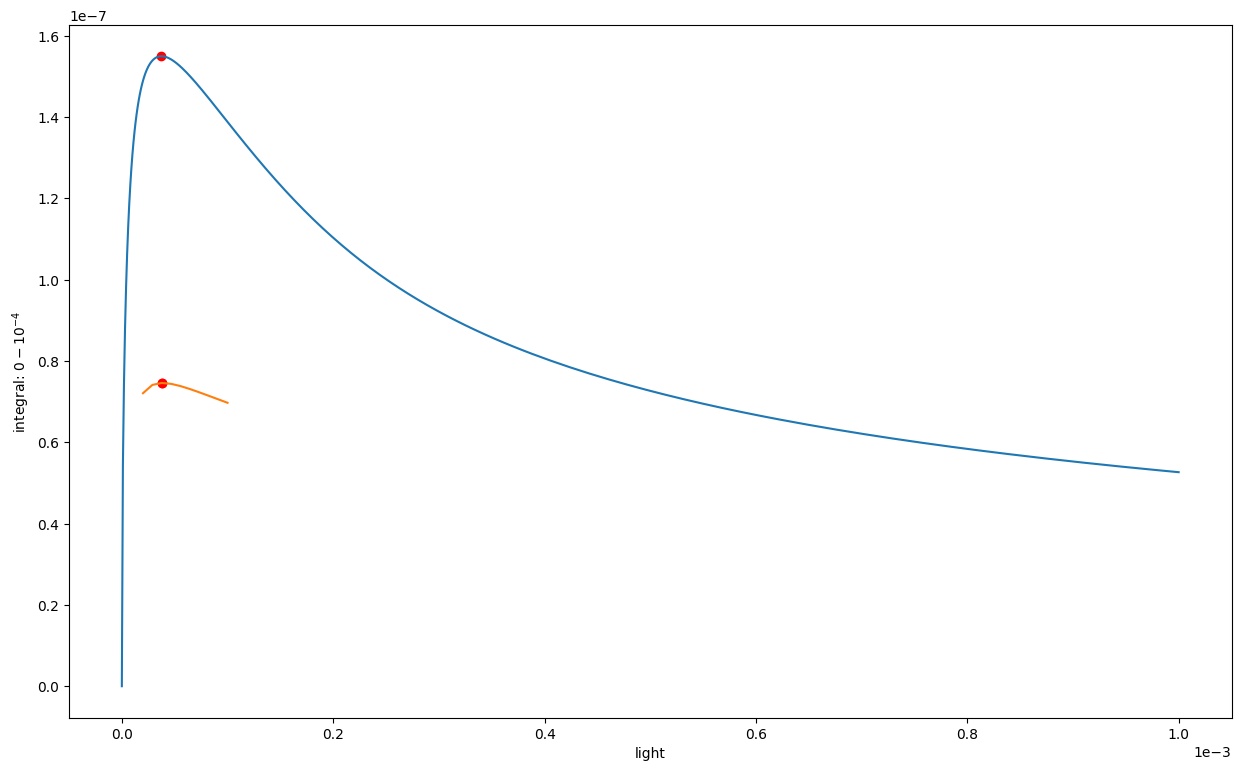

In [16]:
fig, ax = plt.subplots(figsize=(15, 9))
df1 = df[df['flag']==12]
df_max = df1[df1['target'] == df1['target'].max()]
ax.plot(
    df1['light'],
    df1['target'],
)
ax.scatter(
    df_max['light'],
    df_max['target'],
    c='r',
)
max_value = df_max['target'].iloc[0]
max_light = df_max['light'].iloc[0]
print(f'Max value = {max_value:.2E}\nLight     = {max_light:.2E}')


df1 = df[df['flag']==1]
df1 = df1.sort_values(by='light')
df_max = df1[df1['target'] == df1['target'].max()]
ax.plot(
    df1['light'],
    df1['target'],
)
ax.scatter(
    df_max['light'],
    df_max['target'],
    c='r',
)
max_value = df_max['target'].iloc[0]
max_light = df_max['light'].iloc[0]
print(f'Max value = {max_value:.2E}\nLight     = {max_light:.2E}')

ax.set_xlabel('light')
ax.set_ylabel('integral: $0 - 10^{-4}$')
scal_form = ScalarFormatter(1)
scal_form.set_powerlimits((0, 0.1))
ax.xaxis.set_major_formatter(scal_form)

# Add notes

In [17]:
base, old_df = add_notes()